In [1]:
from data_preparation import Preparation
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from statistics import stdev, mean
from sklearn.metrics import mean_absolute_error
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.model_selection import grid_search_forecaster
from missing_timestamps import remove_duplicates


/home/iva/anaconda3/envs/Python_3.9/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


PackageNotFoundError: The 'requests' distribution was not found and is required by this application. 
Try: pip install transformers -U or pip install -e '.[dev]' if you're working with git main

In [2]:
# data setup 
data = Preparation(r'/home/iva/Desktop/operato-meteo-1/data/MAS_processed/ELES-MAS-5001.csv.gz', "AMBIENT_TEMPERATURE")
train, test = data.split()
train["timestamp"] = pd.to_datetime(train["timestamp"])
time_train = train["timestamp"].dt.tz_localize(None)
train["timestamp"] = time_train
train = train.drop_duplicates(subset="timestamp", keep='last')
train = train.set_index('timestamp')
train

root       INFO  Split the dataset to train and test data.


,AMBIENT_TEMPERATURE
timestamp,
2020-10-13 10:20:00,7.4
2020-10-13 10:25:00,7.5
2020-10-13 10:30:00,7.4
2020-10-13 10:35:00,7.5
2020-10-13 10:40:00,7.6
...,...
2022-12-31 23:35:00,0.8
2022-12-31 23:40:00,1.0
2022-12-31 23:45:00,0.8


In [3]:
train[(train.index >= '2020-10-13 10:20:00') * (train.index <= '2020-10-13 12:25:00')]

,AMBIENT_TEMPERATURE
timestamp,
2020-10-13 10:20:00,7.4
2020-10-13 10:25:00,7.5
2020-10-13 10:30:00,7.4
2020-10-13 10:35:00,7.5
2020-10-13 10:40:00,7.6
2020-10-13 10:45:00,7.8
2020-10-13 10:50:00,8.0
2020-10-13 11:00:00,8.3
2020-10-13 11:05:00,8.5


In [4]:
# timeseries to supervised learning problem train data


label_col = 'y'
data = pd.DataFrame(train["AMBIENT_TEMPERATURE"].copy())
data.columns = [label_col]

# add the lag of the target variable from 6 steps back up to 24
for i in range(6, 25):
    data['lag_{}'.format(i)] = data[label_col].shift(i)
    
data['hour'] = data.index.hour
data['weekday'] = data.index.weekday
data[(data.index >= '2020-10-13 10:20:00') * (data.index <= '2020-10-13 13:05:00')]
#data = data.dropna()
#data.head()



,y,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,lag_13,lag_14,...,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,hour,weekday
timestamp,,,,,,,,,,,,,,,,,,,,,
2020-10-13 10:20:00,7.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10,1
2020-10-13 10:25:00,7.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10,1
2020-10-13 10:30:00,7.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10,1
2020-10-13 10:35:00,7.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10,1
2020-10-13 10:40:00,7.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10,1
2020-10-13 10:45:00,7.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10,1
2020-10-13 10:50:00,8.0,7.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10,1
2020-10-13 11:00:00,8.3,7.5,7.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11,1
2020-10-13 11:05:00,8.5,7.4,7.5,7.4,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11,1


In [5]:
data = data.dropna()
data.head()

,y,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,lag_13,lag_14,...,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,hour,weekday
timestamp,,,,,,,,,,,,,,,,,,,,,
2020-10-13 12:25:00,10.2,9.5,9.4,9.3,9.2,9.1,9.1,8.9,8.9,8.7,...,8.3,8.0,7.8,7.6,7.5,7.4,7.5,7.4,12,1
2020-10-13 12:30:00,10.3,9.5,9.5,9.4,9.3,9.2,9.1,9.1,8.9,8.9,...,8.5,8.3,8.0,7.8,7.6,7.5,7.4,7.5,12,1
2020-10-13 12:35:00,10.4,9.7,9.5,9.5,9.4,9.3,9.2,9.1,9.1,8.9,...,8.6,8.5,8.3,8.0,7.8,7.6,7.5,7.4,12,1
2020-10-13 12:40:00,10.5,9.8,9.7,9.5,9.5,9.4,9.3,9.2,9.1,9.1,...,8.7,8.6,8.5,8.3,8.0,7.8,7.6,7.5,12,1
2020-10-13 12:45:00,10.6,9.9,9.8,9.7,9.5,9.5,9.4,9.3,9.2,9.1,...,8.9,8.7,8.6,8.5,8.3,8.0,7.8,7.6,12,1


In [6]:
data["lag_6"]

timestamp
2020-10-13 12:25:00    9.5
2020-10-13 12:30:00    9.5
2020-10-13 12:35:00    9.7
2020-10-13 12:40:00    9.8
2020-10-13 12:45:00    9.9
                      ... 
2022-12-31 23:35:00    0.5
2022-12-31 23:40:00    0.7
2022-12-31 23:45:00    0.8
2022-12-31 23:50:00    0.7
2022-12-31 23:55:00    0.9
Name: lag_6, Length: 228473, dtype: float64

In [7]:

# window statistics
lag_cols = [col for col in data.columns if 'lag' in col]
data['rolling_mean'] = data[lag_cols].mean(axis=1)

# extract out the features and labels into separate variables
y = data[label_col].values
data = data.drop(label_col, axis=1)

X = data.values
feature_names = data.columns
print('dimension: ', X.shape)
data.head()



dimension:  (228473, 22)


,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,lag_13,lag_14,lag_15,...,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,hour,weekday,rolling_mean
timestamp,,,,,,,,,,,,,,,,,,,,,
2020-10-13 12:25:00,9.5,9.4,9.3,9.2,9.1,9.1,8.9,8.9,8.7,8.6,...,8.0,7.8,7.6,7.5,7.4,7.5,7.4,12,1,8.457895
2020-10-13 12:30:00,9.5,9.5,9.4,9.3,9.2,9.1,9.1,8.9,8.9,8.7,...,8.3,8.0,7.8,7.6,7.5,7.4,7.5,12,1,8.568421
2020-10-13 12:35:00,9.7,9.5,9.5,9.4,9.3,9.2,9.1,9.1,8.9,8.9,...,8.5,8.3,8.0,7.8,7.6,7.5,7.4,12,1,8.684211
2020-10-13 12:40:00,9.8,9.7,9.5,9.5,9.4,9.3,9.2,9.1,9.1,8.9,...,8.6,8.5,8.3,8.0,7.8,7.6,7.5,12,1,8.810526
2020-10-13 12:45:00,9.9,9.8,9.7,9.5,9.5,9.4,9.3,9.2,9.1,9.1,...,8.7,8.6,8.5,8.3,8.0,7.8,7.6,12,1,8.936842


In [26]:
X

array([[ 9.5       ,  9.4       ,  9.3       , ..., 12.        ,
         1.        ,  8.45789474],
       [ 9.5       ,  9.5       ,  9.4       , ..., 12.        ,
         1.        ,  8.56842105],
       [ 9.7       ,  9.5       ,  9.5       , ..., 12.        ,
         1.        ,  8.68421053],
       ...,
       [ 0.8       ,  0.7       ,  0.5       , ..., 23.        ,
         5.        ,  0.87894737],
       [ 0.7       ,  0.8       ,  0.7       , ..., 23.        ,
         5.        ,  0.88421053],
       [ 0.9       ,  0.7       ,  0.8       , ..., 23.        ,
         5.        ,  0.88421053]])

In [8]:
# timeseries to supervised learning problem for test data
test["timestamp"] = pd.to_datetime(test["timestamp"])
time_test = test["timestamp"].dt.tz_localize(None)
test["timestamp"] = time_test
test = test.drop_duplicates(subset="timestamp", keep='last')
test = test.set_index('timestamp')
test

,AMBIENT_TEMPERATURE
timestamp,
2023-01-01 00:20:00,0.0
2023-01-01 00:25:00,0.0
2023-01-01 00:30:00,-0.0
2023-01-01 00:35:00,0.0
2023-01-01 00:40:00,0.1
...,...
2023-05-31 21:35:00,14.0
2023-05-31 21:40:00,13.9
2023-05-31 21:45:00,13.9


In [9]:
label_col = 'y'
data_test = pd.DataFrame(test["AMBIENT_TEMPERATURE"].copy())
data_test.columns = [label_col]
# add the lag of the target variable from 6 steps back up to 24
for i in range(6, 25):
    data_test['lag_{}'.format(i)] = data_test[label_col].shift(i)
    
data_test['hour'] = data_test.index.hour
data_test['weekday'] = data_test.index.weekday
data_test[(data_test.index >= '2023-01-01 00:20:00') * (data_test.index <= '2023-01-01 02:20:00')]



,y,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,lag_13,lag_14,...,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,hour,weekday
timestamp,,,,,,,,,,,,,,,,,,,,,
2023-01-01 00:20:00,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,6
2023-01-01 00:25:00,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,6
2023-01-01 00:30:00,-0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,6
2023-01-01 00:35:00,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,6
2023-01-01 00:40:00,0.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,6
2023-01-01 00:45:00,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,6
2023-01-01 00:50:00,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,6
2023-01-01 00:55:00,-0.1,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,6
2023-01-01 01:00:00,0.0,-0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,6


In [31]:
data_test[data_test.index == '2023-01-01 00:30:00']["y"].values

array([-0.])

In [8]:
data_test = data_test.dropna()
data_test

,y,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,lag_13,lag_14,...,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,hour,weekday
timestamp,,,,,,,,,,,,,,,,,,,,,
2023-01-01 02:20:00,0.0,-0.0,-0.3,-0.2,-0.3,-0.2,-0.1,-0.0,-0.1,-0.1,...,-0.1,0.0,0.0,0.1,0.0,-0.0,0.0,0.0,2,6
2023-01-01 02:25:00,0.1,-0.1,-0.0,-0.3,-0.2,-0.3,-0.2,-0.1,-0.0,-0.1,...,0.0,-0.1,0.0,0.0,0.1,0.0,-0.0,0.0,2,6
2023-01-01 02:30:00,0.1,-0.1,-0.1,-0.0,-0.3,-0.2,-0.3,-0.2,-0.1,-0.0,...,0.0,0.0,-0.1,0.0,0.0,0.1,0.0,-0.0,2,6
2023-01-01 02:35:00,0.0,-0.1,-0.1,-0.1,-0.0,-0.3,-0.2,-0.3,-0.2,-0.1,...,-0.1,0.0,0.0,-0.1,0.0,0.0,0.1,0.0,2,6
2023-01-01 02:40:00,0.1,-0.3,-0.1,-0.1,-0.1,-0.0,-0.3,-0.2,-0.3,-0.2,...,-0.1,-0.1,0.0,0.0,-0.1,0.0,0.0,0.1,2,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-05-31 21:35:00,14.0,14.1,14.1,14.1,14.2,14.2,14.3,14.3,14.3,14.4,...,14.5,14.5,14.5,14.6,14.7,14.9,15.0,15.2,21,2
2023-05-31 21:40:00,13.9,14.0,14.1,14.1,14.1,14.2,14.2,14.3,14.3,14.3,...,14.4,14.5,14.5,14.5,14.6,14.7,14.9,15.0,21,2
2023-05-31 21:45:00,13.9,14.0,14.0,14.1,14.1,14.1,14.2,14.2,14.3,14.3,...,14.4,14.4,14.5,14.5,14.5,14.6,14.7,14.9,21,2


In [20]:
data_test["lag_6"]

timestamp
2023-01-01 02:20:00    -0.0
2023-01-01 02:25:00    -0.1
2023-01-01 02:30:00    -0.1
2023-01-01 02:35:00    -0.1
2023-01-01 02:40:00    -0.3
                       ... 
2023-05-31 21:35:00    14.1
2023-05-31 21:40:00    14.0
2023-05-31 21:45:00    14.0
2023-05-31 21:50:00    14.0
2023-05-31 21:55:00    14.0
Name: lag_6, Length: 42987, dtype: float64

In [10]:
data_test["lag_24"]

timestamp
2023-01-01 02:20:00     0.0
2023-01-01 02:25:00     0.0
2023-01-01 02:30:00    -0.0
2023-01-01 02:35:00     0.0
2023-01-01 02:40:00     0.1
                       ... 
2023-05-31 21:35:00    15.2
2023-05-31 21:40:00    15.0
2023-05-31 21:45:00    14.9
2023-05-31 21:50:00    14.7
2023-05-31 21:55:00    14.6
Name: lag_24, Length: 42987, dtype: float64

In [10]:
# window statistics
lag_cols = [col for col in data_test.columns if 'lag' in col]
data_test['rolling_mean'] = data_test[lag_cols].mean(axis=1)

# extract out the features and labels into separate variables
y_test = data_test[label_col].values
data_test = data_test.drop(label_col, axis=1)

X_test = data_test.values
feature_names = data_test.columns
print('dimension: ', X_test.shape)
data_test

dimension:  (43011, 22)


,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,lag_13,lag_14,lag_15,...,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,hour,weekday,rolling_mean
timestamp,,,,,,,,,,,,,,,,,,,,,
2023-01-01 00:20:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,6,NaN
2023-01-01 00:25:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,6,NaN
2023-01-01 00:30:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,6,NaN
2023-01-01 00:35:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,6,NaN
2023-01-01 00:40:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,6,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-05-31 21:35:00,14.1,14.1,14.1,14.2,14.2,14.3,14.3,14.3,14.4,14.4,...,14.5,14.5,14.6,14.7,14.9,15.0,15.2,21,2,14.457895
2023-05-31 21:40:00,14.0,14.1,14.1,14.1,14.2,14.2,14.3,14.3,14.3,14.4,...,14.5,14.5,14.5,14.6,14.7,14.9,15.0,21,2,14.394737
2023-05-31 21:45:00,14.0,14.0,14.1,14.1,14.1,14.2,14.2,14.3,14.3,14.3,...,14.4,14.5,14.5,14.5,14.6,14.7,14.9,21,2,14.342105


In [24]:
X_test

array([[-0.        , -0.3       , -0.2       , ...,  2.        ,
         6.        , -0.06842105],
       [-0.1       , -0.        , -0.3       , ...,  2.        ,
         6.        , -0.07368421],
       [-0.1       , -0.1       , -0.        , ...,  2.        ,
         6.        , -0.07894737],
       ...,
       [14.        , 14.        , 14.1       , ..., 21.        ,
         2.        , 14.34210526],
       [14.        , 14.        , 14.        , ..., 21.        ,
         2.        , 14.29473684],
       [14.        , 14.        , 14.        , ..., 21.        ,
         2.        , 14.25789474]])

In [11]:
# fitting randomforestregressor
model = RandomForestRegressor(max_depth=10, n_estimators=100)
model.fit(X, y)


RandomForestRegressor(max_depth=10)

In [ ]:
predictions = model.predict(X_test)
predictions_dataframe = pd.DataFrame()
predictions_dataframe["timestamp"] = data_test.index
predictions_dataframe["values"] = predictions
predictions_dataframe

In [12]:
predictions = model.predict(864)
predictions_dataframe = pd.DataFrame()
predictions_dataframe["timestamp"] = data_test.index
predictions_dataframe["values"] = predictions
predictions_dataframe

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:1                                                                                    │
│                                                                                                  │
│ ❱ 1 predictions = model.predict(864)                                                             │
│   2 predictions_dataframe = pd.DataFrame()                                                       │
│   3 predictions_dataframe["timestamp"] = data_test.index                                         │
│   4 predictions_dataframe["values"] = predictions                                                │
│                                                                                                  │
│ /home/iva/anaconda3/envs/Python_3.9/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:981  │
│ in predict                                                                                       │
│                                                                                                  │
│    978 │   │   """                                                                               │
│    979 │   │   check_is_fitted(self)                                                             │
│    980 │   │   # Check data                                                                      │
│ ❱  981 │   │   X = self._validate_X_predict(X)                                                   │
│    982 │   │                                                                                     │
│    983 │   │   # Assign chunk of trees to jobs                                                   │
│    984 │   │   n_jobs, _, _ = _partition_estimators(self.n_estimators, self.n_jobs)              │
│                                                                                                  │
│ /home/iva/anaconda3/envs/Python_3.9/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:602  │
│ in _validate_X_predict                                                                           │
│                                                                                                  │
│    599 │   │   """                                                                               │
│    600 │   │   Validate X whenever one tries to predict, apply, predict_proba."""                │
│    601 │   │   check_is_fitted(self)                                                             │
│ ❱  602 │   │   X = self._validate_data(X, dtype=DTYPE, accept_sparse="csr", reset=False)         │
│    603 │   │   if issparse(X) and (X.indices.dtype != np.intc or X.indptr.dtype != np.intc):     │
│    604 │   │   │   raise ValueError("No support for np.int64 index based sparse matrices")       │
│    605 │   │   return X                                                                          │
│                                                                                                  │
│ /home/iva/anaconda3/envs/Python_3.9/lib/python3.9/site-packages/sklearn/base.py:565 in           │
│ _validate_data                                                                                   │
│                                                                                                  │
│    562 │   │   if no_val_X and no_val_y:                                                         │
│    563 │   │   │   raise ValueError("Validation should be done on X, y or both.")                │
│    564 │   │   elif not no_val_X and no_val_y:                                                   │
│ ❱  565 │   │   │   X = check_array(X, input_name="X", **check_params)                            │
│    566 │   │   │   out = X                                                                       │
│    567 │   │   elif no_val_X and not no_val_y:                                                   │
│    568 │   │   │   y = _check_y(y, **check_params)         

In [11]:
test_dataframe = pd.DataFrame()
test_dataframe["timestamp"] = data_test.index
test_dataframe["values"] = y_test
test_dataframe

,timestamp,values
0,2023-01-01 02:20:00,0.0
1,2023-01-01 02:25:00,0.1
2,2023-01-01 02:30:00,0.1
3,2023-01-01 02:35:00,0.0
4,2023-01-01 02:40:00,0.1
...,...,...
42982,2023-05-31 21:35:00,14.0
42983,2023-05-31 21:40:00,13.9
42984,2023-05-31 21:45:00,13.9
42985,2023-05-31 21:50:00,13.9


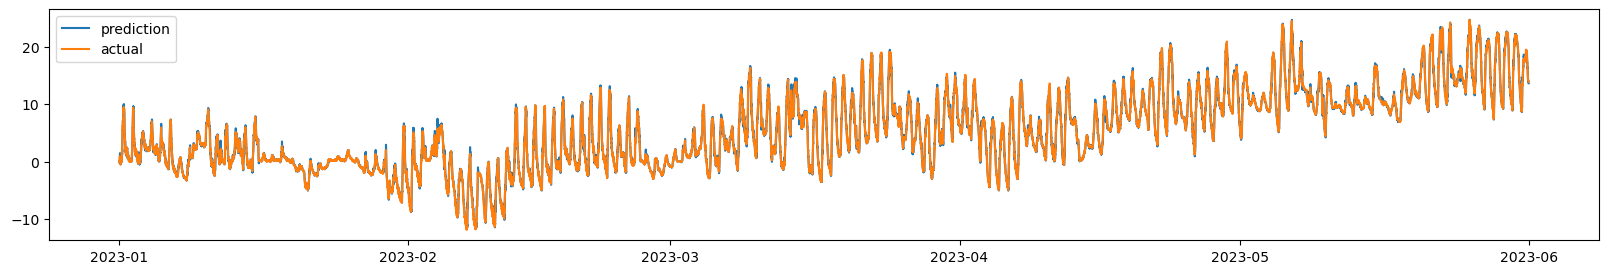

In [13]:
# 5 min forecast
plt.figure(figsize=(20, 3))
plt.plot(data_test.index, predictions, label='prediction')
plt.plot(data_test.index, y_test, label='actual')
plt.legend()

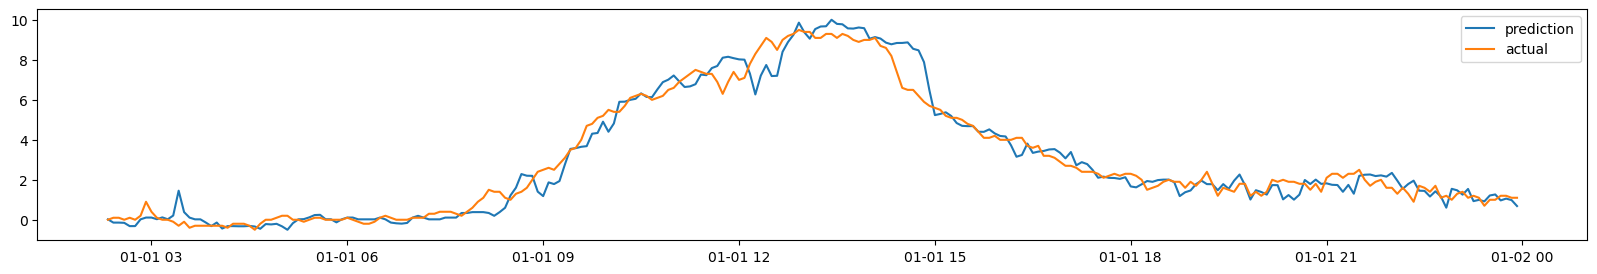

In [14]:
# zoomirano 
zoomed = lambda data, start_time, end_time: data[(data['timestamp'] >= start_time) & (data['timestamp'] <= end_time)]
predictions_zoomed = zoomed(predictions_dataframe, '2023-01-01 2:20:00', '2023-01-01 23:55:00')
test_zoomed = zoomed(test_dataframe, '2023-01-01 2:20:00', '2023-01-01 23:55:00')
plt.figure(figsize=(20, 3))
plt.plot(predictions_zoomed["timestamp"], predictions_zoomed["values"], label='prediction')
plt.plot(test_zoomed["timestamp"], test_zoomed["values"], label='actual')
plt.legend()

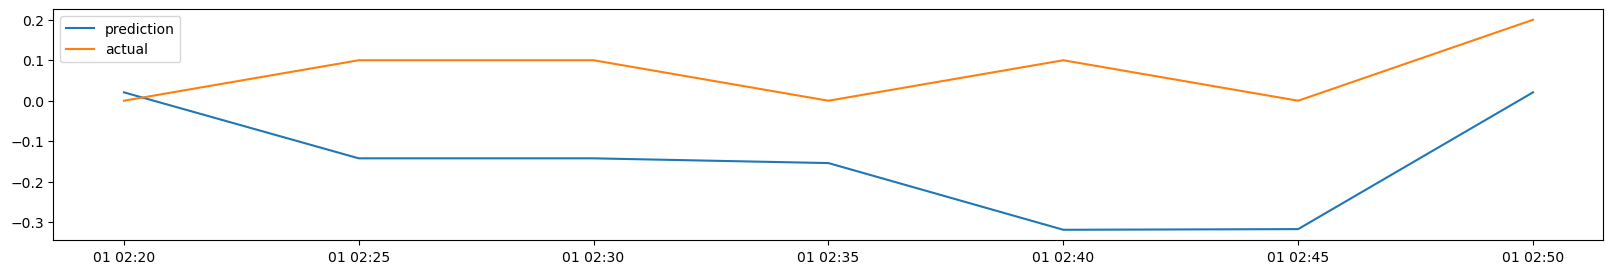

In [15]:
predictions_zoomed_1 = zoomed(predictions_dataframe, '2023-01-01 2:20:00', '2023-01-01 2:50:00')
test_zoomed_1 = zoomed(test_dataframe, '2023-01-01 2:20:00', '2023-01-01 2:50:00')
plt.figure(figsize=(20, 3))
plt.plot(predictions_zoomed_1["timestamp"], predictions_zoomed_1["values"], label='prediction')
plt.plot(test_zoomed_1["timestamp"], test_zoomed_1["values"], label='actual')
plt.legend()

In [16]:
#  mean absolute error
mean_absolute_error(y_test, predictions)

0.31242000184027247

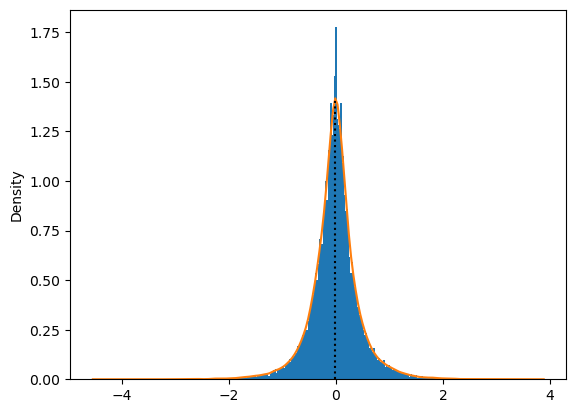

In [17]:
# pdf of error
error= y_test - predictions
plt.hist(error, bins='auto', density=True)
mean_error = mean(error)
ax = sns.kdeplot(data=error)
kdeline = ax.lines[0]
xs = kdeline.get_xdata()
ys = kdeline.get_ydata()
height = np.interp(mean_error, xs, ys)
ax.vlines(mean_error, 0, height, color='black', ls=':')
plt.show()

In [18]:
max(error)

3.717927078543089

In [19]:
print(f"Standard deviation is: {stdev(error)}")
print(f"Mean is: {mean(error)}")

Standard deviation is: 0.46175612172883346
Mean is: -0.01723809102893798


In [23]:
lag = 6
x_6 = list()
y_6 = list()
for t in range(lag, len(train)):
    x_6.append(train['AMBIENT_TEMPERATURE'].iloc[t-lag:t].values)
    y_6.append(train['AMBIENT_TEMPERATURE'].iloc[t])

In [31]:
x_6

[array([7.4, 7.5, 7.4, 7.5, 7.6, 7.8]),
 array([7.5, 7.4, 7.5, 7.6, 7.8, 8. ]),
 array([7.4, 7.5, 7.6, 7.8, 8. , 8.3]),
 array([7.5, 7.6, 7.8, 8. , 8.3, 8.5]),
 array([7.6, 7.8, 8. , 8.3, 8.5, 8.6]),
 array([7.8, 8. , 8.3, 8.5, 8.6, 8.7]),
 array([8. , 8.3, 8.5, 8.6, 8.7, 8.9]),
 array([8.3, 8.5, 8.6, 8.7, 8.9, 8.9]),
 array([8.5, 8.6, 8.7, 8.9, 8.9, 9.1]),
 array([8.6, 8.7, 8.9, 8.9, 9.1, 9.1]),
 array([8.7, 8.9, 8.9, 9.1, 9.1, 9.2]),
 array([8.9, 8.9, 9.1, 9.1, 9.2, 9.3]),
 array([8.9, 9.1, 9.1, 9.2, 9.3, 9.4]),
 array([9.1, 9.1, 9.2, 9.3, 9.4, 9.5]),
 array([9.1, 9.2, 9.3, 9.4, 9.5, 9.5]),
 array([9.2, 9.3, 9.4, 9.5, 9.5, 9.7]),
 array([9.3, 9.4, 9.5, 9.5, 9.7, 9.8]),
 array([9.4, 9.5, 9.5, 9.7, 9.8, 9.9]),
 array([ 9.5,  9.5,  9.7,  9.8,  9.9, 10. ]),
 array([ 9.5,  9.7,  9.8,  9.9, 10. , 10.2]),
 array([ 9.7,  9.8,  9.9, 10. , 10.2, 10.3]),
 array([ 9.8,  9.9, 10. , 10.2, 10.3, 10.4]),
 array([ 9.9, 10. , 10.2, 10.3, 10.4, 10.5]),
 array([10. , 10.2, 10.3, 10.4, 10.5, 10.6]),
 arr

In [32]:
y_6

[8.0,
 8.3,
 8.5,
 8.6,
 8.7,
 8.9,
 8.9,
 9.1,
 9.1,
 9.2,
 9.3,
 9.4,
 9.5,
 9.5,
 9.7,
 9.8,
 9.9,
 10.0,
 10.2,
 10.3,
 10.4,
 10.5,
 10.6,
 10.6,
 10.7,
 10.7,
 10.7,
 10.8,
 10.8,
 10.7,
 10.8,
 10.7,
 10.7,
 10.7,
 10.6,
 10.7,
 10.7,
 10.7,
 10.7,
 10.8,
 10.8,
 10.8,
 10.8,
 10.8,
 10.9,
 11.0,
 11.0,
 10.9,
 10.8,
 10.8,
 10.6,
 10.5,
 10.5,
 10.2,
 9.9,
 9.6,
 9.5,
 9.4,
 9.2,
 9.1,
 8.9,
 8.7,
 8.7,
 8.5,
 8.4,
 8.3,
 8.2,
 8.0,
 7.9,
 7.8,
 7.7,
 7.6,
 7.5,
 7.4,
 7.3,
 7.2,
 7.1,
 7.0,
 6.9,
 6.9,
 6.8,
 6.7,
 6.6,
 6.5,
 6.4,
 6.4,
 6.3,
 6.3,
 6.3,
 6.3,
 6.2,
 6.1,
 6.1,
 6.1,
 6.2,
 6.2,
 6.2,
 6.2,
 6.1,
 6.1,
 6.1,
 6.1,
 6.1,
 5.9,
 5.9,
 5.8,
 5.9,
 5.8,
 5.7,
 5.7,
 5.7,
 5.7,
 5.6,
 5.6,
 5.6,
 5.7,
 5.7,
 5.7,
 5.6,
 5.5,
 5.4,
 5.3,
 5.2,
 5.1,
 5.1,
 5.0,
 4.9,
 4.7,
 4.6,
 4.5,
 4.5,
 4.2,
 4.1,
 4.0,
 4.2,
 4.5,
 4.5,
 4.2,
 4.0,
 3.8,
 3.7,
 3.6,
 3.4,
 3.3,
 3.3,
 3.1,
 3.1,
 3.2,
 3.2,
 3.1,
 3.2,
 3.1,
 2.8,
 2.7,
 2.7,
 2.6,
 2.6,
 2.7,
 2.6,
 2.5,
 2.

In [33]:
# fittting the model with input features ((t-6), (t-5), (t-4), (t-3), (t-2), (t-1)) and output feature t
model_1= RandomForestRegressor(max_depth=10, n_estimators=100)
model_1.fit(x_6, y_6)

RandomForestRegressor(max_depth=10)

In [24]:
x_ = train['AMBIENT_TEMPERATURE'].iloc[-lag:].values
x_

array([1. , 0.8, 1. , 0.8, 0.6, 0.4])

In [39]:
# 72h multistep forecast recursive method 
# 864*5min = 4320 min deljeno z 60 = 72h
p = np.zeros(864)
x_ = train['AMBIENT_TEMPERATURE'].iloc[-lag:].values
for t in range(864):
    p[t] = model_1.predict([x_])
    x_ = np.roll(x_, -1)
    # removing the oldest one value and addding the predicted
    x_[-1] = p[t]

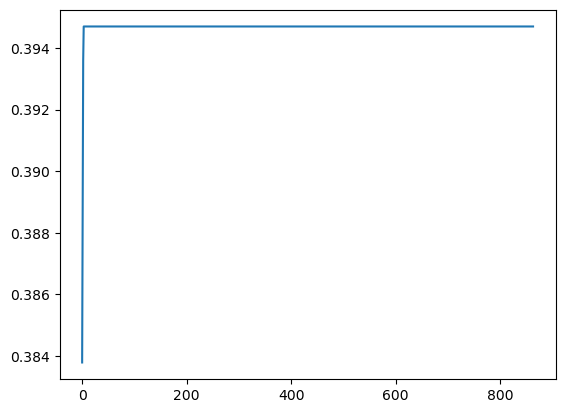

In [45]:
plt.plot(p)


In [26]:
train

,AMBIENT_TEMPERATURE
timestamp,
2020-10-13 10:20:00,7.4
2020-10-13 10:25:00,7.5
2020-10-13 10:30:00,7.4
2020-10-13 10:35:00,7.5
2020-10-13 10:40:00,7.6
...,...
2022-12-31 23:35:00,0.8
2022-12-31 23:40:00,1.0
2022-12-31 23:45:00,0.8


In [54]:
# data setup 
data = Preparation(r'/home/iva/Desktop/operato-meteo-1/data/MAS_processed/ELES-MAS-5001.csv.gz', "AMBIENT_TEMPERATURE")
train, test = data.split()
train["timestamp"] = pd.to_datetime(train["timestamp"])
time_train = train["timestamp"].dt.tz_localize(None)
train["timestamp"] = time_train
train = train.drop_duplicates(subset="timestamp", keep='last')
train_regular = train.set_index("timestamp")
train_regular = train_regular.asfreq("5T")
#train_regular = train_regular.dropna()
train_regular = train_regular.fillna(method="ffill")
train_regular

,AMBIENT_TEMPERATURE
timestamp,
2020-10-13 10:20:00,7.4
2020-10-13 10:25:00,7.5
2020-10-13 10:30:00,7.4
2020-10-13 10:35:00,7.5
2020-10-13 10:40:00,7.6
...,...
2022-12-31 23:35:00,0.8
2022-12-31 23:40:00,1.0
2022-12-31 23:45:00,0.8


In [55]:
x = pd.infer_freq(train_regular.index)
print(x)

5T


In [56]:
# skforecast library with recursive method for multistep forecasting
train_ = train_regular["AMBIENT_TEMPERATURE"].copy().squeeze()
forecaster = ForecasterAutoreg(regressor=RandomForestRegressor(max_depth=10, n_estimators=100), lags=36)
forecaster.fit(y=train_)
forecaster


ForecasterAutoreg 
Regressor: RandomForestRegressor(max_depth=10) 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36] 
Transformer for y: None 
Transformer for exog: None 
Window size: 36 
Weight function included: False 
Differentiation order: None 
Exogenous included: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [Timestamp('2020-10-13 10:20:00'), Timestamp('2022-12-31 23:55:00')] 
Training index type: DatetimeIndex 
Training index frequency: 5T 
Regressor parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': 10, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False} 
fit_kwargs: {} 
Creation date: 2023-09-

In [57]:
predictions = forecaster.predict(steps=864)
predictions

2023-01-01 00:00:00    0.393731
2023-01-01 00:05:00    0.395244
2023-01-01 00:10:00    0.395404
2023-01-01 00:15:00    0.394454
2023-01-01 00:20:00    0.395404
                         ...   
2023-01-03 23:35:00    0.396045
2023-01-03 23:40:00    0.396045
2023-01-03 23:45:00    0.396045
2023-01-03 23:50:00    0.396045
2023-01-03 23:55:00    0.396045
Freq: 5T, Name: pred, Length: 864, dtype: float64

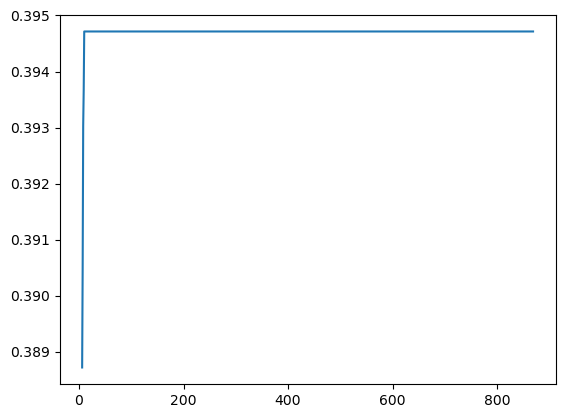

In [30]:
plt.plot(predictions)

In [2]:
data = Preparation(r'/home/iva/Desktop/operato-meteo-1/data/MAS_processed/ELES-MAS-5001.csv.gz', "AMBIENT_TEMPERATURE")
train, test = data.split()
train_processed = remove_duplicates(train)
train_processed_ = train_processed["AMBIENT_TEMPERATURE"].copy().squeeze()
test_processed = remove_duplicates(test)
test_processed_ = test_processed["AMBIENT_TEMPERATURE"].copy().squeeze()


root       INFO  Split the dataset to train and test data.


In [4]:
whole_data = pd.concat([train_processed_, test_processed_])
whole_data

timestamp
2020-10-13 10:20:00     7.4
2020-10-13 10:25:00     7.5
2020-10-13 10:30:00     7.4
2020-10-13 10:35:00     7.5
2020-10-13 10:40:00     7.6
                       ... 
2023-05-31 21:35:00    14.0
2023-05-31 21:40:00    13.9
2023-05-31 21:45:00    13.9
2023-05-31 21:50:00    13.9
2023-05-31 21:55:00    13.9
Name: AMBIENT_TEMPERATURE, Length: 271508, dtype: float64

In [5]:
whole_data.loc[:"2022"]

timestamp
2020-10-13 10:20:00    7.4
2020-10-13 10:25:00    7.5
2020-10-13 10:30:00    7.4
2020-10-13 10:35:00    7.5
2020-10-13 10:40:00    7.6
                      ... 
2022-12-31 23:35:00    0.8
2022-12-31 23:40:00    1.0
2022-12-31 23:45:00    0.8
2022-12-31 23:50:00    0.6
2022-12-31 23:55:00    0.4
Name: AMBIENT_TEMPERATURE, Length: 228497, dtype: float64

In [16]:
forecaster = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state=123),
                lags = 36 # Placeholder, the value will be overwritten
             )

# Regressor hyperparameters
param_grid = {'n_estimators': [50, 100],
              'max_depth': [5, 10, 15]}

# Lags used as predictors
lags_grid = [3, 10, [1, 2, 3, 20]]

results_grid = grid_search_forecaster(
                        forecaster = forecaster,
                        y = whole_data,
                        param_grid = param_grid,
                        lags_grid = lags_grid,
                        steps = 12,
                        refit = True,
                        metric = 'mean_squared_error',
                        initial_train_size = len(test_processed_),
                        return_best = True,
                        verbose  = False
                    )

Number of models compared: 18.


lags grid:   0%|          | 0/3 [00:00<?, ?it/s]/home/iva/anaconda3/envs/Python_3.9/lib/python3.9/site-packages/skforecast/utils/utils.py:788: UserWarning: `y` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  warnings.warn(
/home/iva/anaconda3/envs/Python_3.9/lib/python3.9/site-packages/skforecast/utils/utils.py:788: UserWarning: `y` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  warnings.warn(
/home/iva/anaconda3/envs/Python_3.9/lib/python3.9/site-packages/skforecast/model_selection/model_selection.py:550: LongTrainingWarning: The forecaster will be fit 15458 times. This can take substantial amounts of time. If not feasible, try with `refit = False`.
 
 You can suppress this warning using: warnings.simplefilter('ignore', category=LongTrainingWarning)
  warnings.warn(
/home/iva/anaconda3/envs/Python_3.9/lib/python3.9/site-packages/skforecast/utils/utils.py:788: UserWarning: `y` has DatetimeIndex

In [15]:
results_grid

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:1                                                                                    │
│                                                                                                  │
│ ❱ 1 results_grid                                                                                 │
│   2                                                                                              │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
NameError: name 'results_grid' is not defined

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.model_selection import grid_search_forecaster
from sklearn.metrics import mean_squared_error

/home/iva/anaconda3/envs/Python_3.9/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [14]:
from data_preparation import Preparation
from missing_timestamps import remove_duplicates
import pandas as pd
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.model_selection import grid_search_forecaster
from sklearn.ensemble import RandomForestRegressor

torch.distributed.nn.jit.instantiator INFO  Created a temporary directory at /tmp/tmpb98n2tur
torch.distributed.nn.jit.instantiator INFO  Writing /tmp/tmpb98n2tur/_remote_module_non_scriptable.py


In [19]:
len(whole_data.loc[:"2022"])

228497

In [16]:
predictions = forecaster.predict(steps=864)
predictions

/home/iva/anaconda3/envs/Python_3.9/lib/python3.9/site-packages/skforecast/utils/utils.py:850: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  warnings.warn(


36     0.396173
37     0.396173
38     0.396173
39     0.396173
40     0.396173
         ...   
895    0.396173
896    0.396173
897    0.396173
898    0.396173
899    0.396173
Name: pred, Length: 864, dtype: float64

In [2]:
from data_preparation import Preparation
from missing_timestamps import remove_duplicates
import pandas as pd
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.model_selection import grid_search_forecaster
from sklearn.ensemble import RandomForestRegressor
from skforecast.utils import save_forecaster
from skforecast.utils import load_forecaster

/home/iva/anaconda3/envs/Python_3.9/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [11]:
# marvin
#data = Preparation(r'/home/ieftimska/operato-meteo-1/data/MAS_processed/ELES-MAS-5001.csv.gz', "AMBIENT_TEMPERATURE")
data = Preparation(r'/home/iva/Desktop/operato-meteo-1/data/MAS_processed/ELES-MAS-5001.csv.gz', "AMBIENT_TEMPERATURE")
train, test = data.split()
train_processed = remove_duplicates(train)
train_processed_ = train_processed["AMBIENT_TEMPERATURE"].copy().squeeze()
#train_processed_ = train_processed.asfreq("5T").fillna(method="ffill")
test_processed = remove_duplicates(test)
test_processed_ = test_processed["AMBIENT_TEMPERATURE"].copy().squeeze()
#test_processed_ = test_processed.asfreq("5T").fillna(method="ffill")
whole_data = pd.concat([train_processed, test_processed])
whole_data = whole_data.rename(columns={"AMBIENT_TEMPERATURE": "y"})
whole_data.index = whole_data.index.rename("datetime")
whole_data_ = whole_data["y"].copy().squeeze()
print(whole_data_)

root       INFO  Split the dataset to train and test data.


datetime
2020-10-13 10:20:00     7.4
2020-10-13 10:25:00     7.5
2020-10-13 10:30:00     7.4
2020-10-13 10:35:00     7.5
2020-10-13 10:40:00     7.6
                       ... 
2023-05-31 21:35:00    14.0
2023-05-31 21:40:00    13.9
2023-05-31 21:45:00    13.9
2023-05-31 21:50:00    13.9
2023-05-31 21:55:00    13.9
Name: y, Length: 271508, dtype: float64


In [27]:
train_processed_

,AMBIENT_TEMPERATURE
timestamp,
2020-10-13 10:20:00,7.4
2020-10-13 10:25:00,7.5
2020-10-13 10:30:00,7.4
2020-10-13 10:35:00,7.5
2020-10-13 10:40:00,7.6
...,...
2022-12-31 23:35:00,0.8
2022-12-31 23:40:00,1.0
2022-12-31 23:45:00,0.8


In [6]:
forecaster = ForecasterAutoreg(regressor=RandomForestRegressor(random_state=123, n_jobs=-1, max_depth=10, n_estimators=100), lags=865)
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [5, 10, 15]
}
X_eval, y_eval = forecaster.create_train_X_y(y=whole_data_)
print(type(y_eval))
forecaster_real = ForecasterAutoreg(regressor=RandomForestRegressor(random_state=123, n_jobs=-1, max_depth=10, n_estimators=100), lags=865,  fit_kwargs={'eval_set': [(X_eval, y_eval)]})
forecaster_real.fit(x=X_eval, y=y_eval)


/home/iva/anaconda3/envs/Python_3.9/lib/python3.9/site-packages/skforecast/utils/utils.py:788: UserWarning: `y` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  warnings.warn(


<class 'pandas.core.series.Series'>


/home/iva/anaconda3/envs/Python_3.9/lib/python3.9/site-packages/skforecast/utils/utils.py:214: IgnoredArgumentWarning: Argument/s ['eval_set'] ignored since they are not used by the regressor's `fit` method. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=IgnoredArgumentWarning)
  warnings.warn(


╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:9                                                                                    │
│                                                                                                  │
│    6 X_eval, y_eval = forecaster.create_train_X_y(y=whole_data_)                                 │
│    7 print(type(y_eval))                                                                         │
│    8 forecaster_real = ForecasterAutoreg(regressor=RandomForestRegressor(random_state=123, n_    │
│ ❱  9 forecaster_real.fit(x=X_eval, y=y_eval)                                                     │
│   10                                                                                             │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
TypeError: fit() got an unexpected keyword argument 'x'

In [28]:

forecaster = ForecasterAutoreg(regressor=RandomForestRegressor(random_state=123, n_jobs=-1, max_depth=10, n_estimators=100), lags=24)
X_eval, y_eval = forecaster.create_train_X_y(y=whole_data_)

/home/iva/anaconda3/envs/Python_3.9/lib/python3.9/site-packages/skforecast/utils/utils.py:788: UserWarning: `y` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  warnings.warn(


In [29]:
display(X_eval)

,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,...,lag_15,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24
24,9.9,9.8,9.7,9.5,9.5,9.4,9.3,9.2,9.1,9.1,...,8.5,8.3,8.0,8.0,7.8,7.6,7.5,7.4,7.5,7.4
25,10.0,9.9,9.8,9.7,9.5,9.5,9.4,9.3,9.2,9.1,...,8.6,8.5,8.3,8.0,8.0,7.8,7.6,7.5,7.4,7.5
26,10.2,10.0,9.9,9.8,9.7,9.5,9.5,9.4,9.3,9.2,...,8.7,8.6,8.5,8.3,8.0,8.0,7.8,7.6,7.5,7.4
27,10.3,10.2,10.0,9.9,9.8,9.7,9.5,9.5,9.4,9.3,...,8.9,8.7,8.6,8.5,8.3,8.0,8.0,7.8,7.6,7.5
28,10.4,10.3,10.2,10.0,9.9,9.8,9.7,9.5,9.5,9.4,...,8.9,8.9,8.7,8.6,8.5,8.3,8.0,8.0,7.8,7.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
276611,14.0,14.0,14.0,14.0,14.0,14.1,14.1,14.1,14.2,14.2,...,14.4,14.4,14.5,14.5,14.5,14.6,14.7,14.9,15.0,15.2
276612,14.0,14.0,14.0,14.0,14.0,14.0,14.1,14.1,14.1,14.2,...,14.4,14.4,14.4,14.5,14.5,14.5,14.6,14.7,14.9,15.0
276613,13.9,14.0,14.0,14.0,14.0,14.0,14.0,14.1,14.1,14.1,...,14.3,14.4,14.4,14.4,14.5,14.5,14.5,14.6,14.7,14.9
276614,13.9,13.9,14.0,14.0,14.0,14.0,14.0,14.0,14.1,14.1,...,14.3,14.3,14.4,14.4,14.4,14.5,14.5,14.5,14.6,14.7


In [20]:
data

,y,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,lag_13,lag_14,...,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,hour,weekday
timestamp,,,,,,,,,,,,,,,,,,,,,
2020-10-13 12:25:00,10.2,9.5,9.4,9.3,9.2,9.1,9.1,8.9,8.9,8.7,...,8.3,8.0,7.8,7.6,7.5,7.4,7.5,7.4,12,1
2020-10-13 12:30:00,10.3,9.5,9.5,9.4,9.3,9.2,9.1,9.1,8.9,8.9,...,8.5,8.3,8.0,7.8,7.6,7.5,7.4,7.5,12,1
2020-10-13 12:35:00,10.4,9.7,9.5,9.5,9.4,9.3,9.2,9.1,9.1,8.9,...,8.6,8.5,8.3,8.0,7.8,7.6,7.5,7.4,12,1
2020-10-13 12:40:00,10.5,9.8,9.7,9.5,9.5,9.4,9.3,9.2,9.1,9.1,...,8.7,8.6,8.5,8.3,8.0,7.8,7.6,7.5,12,1
2020-10-13 12:45:00,10.6,9.9,9.8,9.7,9.5,9.5,9.4,9.3,9.2,9.1,...,8.9,8.7,8.6,8.5,8.3,8.0,7.8,7.6,12,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-31 23:35:00,0.8,0.5,0.8,0.9,1.1,0.9,0.8,0.7,0.7,0.7,...,1.3,1.2,1.2,1.0,0.9,0.6,0.5,0.6,23,5
2022-12-31 23:40:00,1.0,0.7,0.5,0.8,0.9,1.1,0.9,0.8,0.7,0.7,...,1.2,1.3,1.2,1.2,1.0,0.9,0.6,0.5,23,5
2022-12-31 23:45:00,0.8,0.8,0.7,0.5,0.8,0.9,1.1,0.9,0.8,0.7,...,0.7,1.2,1.3,1.2,1.2,1.0,0.9,0.6,23,5


In [9]:
len(train_)

228503

In [1]:
from xgboost import XGBRegressor


In [29]:
forecaster = ForecasterAutoreg(
                 regressor = XGBRegressor(),
                 lags = 1728
             )
forecaster.fit(y=train_processed_)

/home/iva/anaconda3/envs/Python_3.9/lib/python3.9/site-packages/skforecast/utils/utils.py:788: UserWarning: `y` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  warnings.warn(


: 

In [26]:
predictions_xgb = forecaster.predict(steps=864)
print(predictions_xgb)

/home/iva/anaconda3/envs/Python_3.9/lib/python3.9/site-packages/skforecast/utils/utils.py:850: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  warnings.warn(


24     0.394770
25     0.394770
26     0.394770
27     0.394770
28     0.394770
         ...   
883    0.402075
884    0.402075
885    0.402075
886    0.402075
887    0.402075
Name: pred, Length: 864, dtype: float64


In [13]:
test_processed_[:864]

timestamp
2023-01-01 00:20:00    0.0
2023-01-01 00:25:00    0.0
2023-01-01 00:30:00   -0.0
2023-01-01 00:35:00    0.0
2023-01-01 00:40:00    0.1
                      ... 
2023-01-04 00:05:00    2.0
2023-01-04 00:10:00    2.0
2023-01-04 00:15:00    2.0
2023-01-04 00:20:00    2.0
2023-01-04 00:25:00    2.0
Name: AMBIENT_TEMPERATURE, Length: 864, dtype: float64

In [18]:
len(predictions_xgb)

864

In [27]:
forecaster.get_feature_importances()

,feature,importance
0,lag_1,0.998928
1,lag_2,0.000028
2,lag_3,0.000021
3,lag_4,0.000025
4,lag_5,0.000021
5,lag_6,0.000023
6,lag_7,0.000027
7,lag_8,0.000030
8,lag_9,0.000038
9,lag_10,0.000038


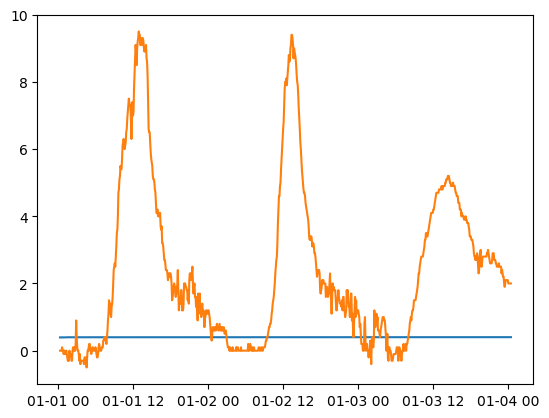

In [28]:
plt.plot(test_processed_[:864].index, predictions_xgb)
plt.plot(test_processed_[:864].index, test_processed_[:864].values)
